Modelo de Regresión Lineal en Python
====================================

Ya creamos un modelo de predicción de la altura de una persona dados datos de sus restos óseos, utilizando el algoritmo de regresión lineal en RapidMiner. Ahora vamos a hacer lo mismo en Python.



In [115]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Carga de datos

Utilizaremos el mismo procedimiento de carga de datos que usamos en el análisis exploratorio de datos. Para ello, importamos las librerías necesarias y cargamos el fichero de datos.

In [116]:
db_dir = "datasets\originales\Knogler.accdb"
SQLALCHEMY_DATABASE_URI = os.path.abspath(db_dir).replace("\\", "\\\\")

connection_string = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    rf"DBQ={SQLALCHEMY_DATABASE_URI};"
    r"ExtendedAnsiSQL=1;"
)
connection_url = sa.engine.URL.create(
    "access+pyodbc",
    query={"odbc_connect": connection_string}
)

engine = sa.create_engine(connection_url)
df = pd.read_sql("SELECT * FROM Dataindsamling", engine)

print(df.head())

   ID Location Site_Number  Age_Minumum  Age_Maximum   Sex Grave Number  \
0   1     Ribe     ASR1015         20.0         24.0  Male          G40   
1   4     Ribe     ASR1015         35.0         45.0  Male         G312   
2   5     Ribe     ASR1015         50.0         60.0  Male         G229   
3   6     Ribe     ASR1015         30.0         40.0  Male         G257   
4   7     Ribe     ASR1015         45.0         55.0  Male          G74   

   Canine number  Canine largest age  Canine 2nd largest age  ...  \
0            2.0                 3.0                     5.0  ...   
1            3.0                 4.0                     4.5  ...   
2            0.0                 0.0                     0.0  ...   
3            NaN                 NaN                     NaN  ...   
4            NaN                 NaN                     NaN  ...   

   Height in grave                            Abnormalities Vertebras  \
0            173.5                                           

In [117]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       117 non-null    int64         
 1   Location                 117 non-null    object        
 2   Site_Number              117 non-null    object        
 3   Age_Minumum              117 non-null    float64       
 4   Age_Maximum              110 non-null    float64       
 5   Sex                      115 non-null    object        
 6   Grave Number             117 non-null    object        
 7   Canine number            89 non-null     float64       
 8   Canine largest age       83 non-null     float64       
 9   Canine 2nd largest age   76 non-null     float64       
 10  Incisor number           77 non-null     float64       
 11  Incisor largest age      75 non-null     float64       
 12  Incisor 2nd largest age  72 non-null

## Preprocesamiento

Intentaremos seguir el mismo procedimiento que el que realizamos en el preprocesamiento de los datos para RapidMiner. La primera tarea es el filtrado de datos que no nos sirven para el caso. Removemos las columnas que no nos interesan.

In [118]:
df = df.drop(['Date', 'Grave Number', 'Location', 'Notes', 'Signature', 'Site_Number', 'ID'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age_Minumum              117 non-null    float64
 1   Age_Maximum              110 non-null    float64
 2   Sex                      115 non-null    object 
 3   Canine number            89 non-null     float64
 4   Canine largest age       83 non-null     float64
 5   Canine 2nd largest age   76 non-null     float64
 6   Incisor number           77 non-null     float64
 7   Incisor largest age      75 non-null     float64
 8   Incisor 2nd largest age  72 non-null     float64
 9   Height in grave          117 non-null    float64
 10  Abnormalities Vertebras  13 non-null     object 
 11  Femur left               92 non-null     float64
 12  Femur right              90 non-null     float64
 13  Abnormalities Femur      11 non-null     object 
 14  Hyperplasia              1

Tambien removemos las columnas con demasiados valores nulos. En especial aquellas con mas de 30 valores nulos.

In [119]:
examples_count = df.shape[0]
df = df.dropna(axis=1, thresh=int(examples_count - 30))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age_Minumum      117 non-null    float64
 1   Age_Maximum      110 non-null    float64
 2   Sex              115 non-null    object 
 3   Canine number    89 non-null     float64
 4   Height in grave  117 non-null    float64
 5   Femur left       92 non-null     float64
 6   Femur right      90 non-null     float64
 7   Hyperplasia      117 non-null    bool   
 8   Teeth Scorable   117 non-null    bool   
dtypes: bool(2), float64(6), object(1)
memory usage: 6.8+ KB
None


Pasemos ahora a la imputación de valores nulos. Para ello, utilizaremos la moda de los valores del atributo. Esto solo lo haremos para `Canine number`. Los otros atributos con valores faltantes se usaran para filtrar ejemplos incompletos.

In [120]:
df['Canine number'] = df['Canine number'].fillna(df['Canine number'].mode())

El resto de los ejemplos con valores nulos seran eliminados.

In [121]:
df = df.dropna(axis=0)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 114
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age_Minumum      59 non-null     float64
 1   Age_Maximum      59 non-null     float64
 2   Sex              59 non-null     object 
 3   Canine number    59 non-null     float64
 4   Height in grave  59 non-null     float64
 5   Femur left       59 non-null     float64
 6   Femur right      59 non-null     float64
 7   Hyperplasia      59 non-null     bool   
 8   Teeth Scorable   59 non-null     bool   
dtypes: bool(2), float64(6), object(1)
memory usage: 3.8+ KB
None


En este punto ya tenemos un conjunto de datos completo de 59 ejemplos. Para poder aplicar el algoritmo de regresión lineal, debemos convertir los valores de los atributos a valores numéricos.

In [122]:
df['Sex'] = df['Sex'].replace(['Male', 'Female'], [0, 1]).astype(int)
df['Hyperplasia'] = df['Hyperplasia'].astype(int)
df['Teeth Scorable'] = df['Teeth Scorable'].astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 114
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age_Minumum      59 non-null     float64
 1   Age_Maximum      59 non-null     float64
 2   Sex              59 non-null     int32  
 3   Canine number    59 non-null     float64
 4   Height in grave  59 non-null     float64
 5   Femur left       59 non-null     float64
 6   Femur right      59 non-null     float64
 7   Hyperplasia      59 non-null     int32  
 8   Teeth Scorable   59 non-null     int32  
dtypes: float64(6), int32(3)
memory usage: 3.9 KB
None


Proximo paso es remover los atributos correlacionados. Esto lo realizamos utilizando una matriz de correlación y eliminando aquellos atributos con un valor de correlación mayor a 0.35.

In [123]:
correlation_matrix = df.drop(['Height in grave'], axis=1).corr().abs()

upper = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > 0.35)]

df = df.drop(df[to_drop], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 114
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age_Minumum      59 non-null     float64
 1   Sex              59 non-null     int32  
 2   Canine number    59 non-null     float64
 3   Height in grave  59 non-null     float64
 4   Femur left       59 non-null     float64
dtypes: float64(4), int32(1)
memory usage: 2.5 KB
None


Siguiente, vamos a remover aquellos atributos que tengan datos anomalos.

In [124]:
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit(df)
df['outlier'] = -lof.negative_outlier_factor_

df = df[df['outlier'] <= 2]
df = df.drop(['outlier'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 0 to 114
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age_Minumum      54 non-null     float64
 1   Sex              54 non-null     int32  
 2   Canine number    54 non-null     float64
 3   Height in grave  54 non-null     float64
 4   Femur left       54 non-null     float64
dtypes: float64(4), int32(1)
memory usage: 2.3 KB
None


Como ultimo paso del preprocesamiento de datos, vamos a preparar una optimizacion de atributos basada en pesos de esos. Lo realizamos utilizando `SelectFromModel`, y un modelo de regresión lineal. Nos aseguramos tambien de preparar un paso de normalización donde sea necesario.

In [125]:
pipeline_for_selection = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

def coef_getter(estimator):
    return estimator.named_steps['regression'].coef_

selector = SelectFromModel(pipeline_for_selection, threshold='mean', importance_getter=coef_getter)

Con esto, el preprocesamiento esta finalizado. Pasemos a la etapa de entrenamiento.

## Entrenamiento

Para entrenar el modelo, vamos a utilizar un algoritmo de regresión lineal. Para ello, importamos la librería de regresión lineal de scikit-learn. Realizamos el proceso dentro de un pipline con el preprocesamiento de selección de atributos y normalización. Esto lon hacemos dentro de una validación cruzada de 10 folds.

In [126]:
inputs = df.drop(['Height in grave'], axis=1)
outputs = df['Height in grave']

pipeline_for_training = Pipeline([
    ('feature_selection', selector),
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

predictions = cross_val_predict(pipeline_for_training, inputs, outputs, cv=10)

## Evaluación

Para evaluar el modelo, vamos a utilizar el RMSE y el R2. Para ello, importamos las librerías necesarias y calculamos los valores.

In [127]:
mae = mean_absolute_error(outputs, predictions)
mse = mean_squared_error(outputs, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(outputs, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 2.9317051721609793
Mean Squared Error (MSE): 13.889753225894177
Root Mean Squared Error (RMSE): 3.7268959236735033
R-squared: 0.8707233999011896


Pasemos a graficar el valor real contra el valor predicho. Para mejor visualizar las diferencias.

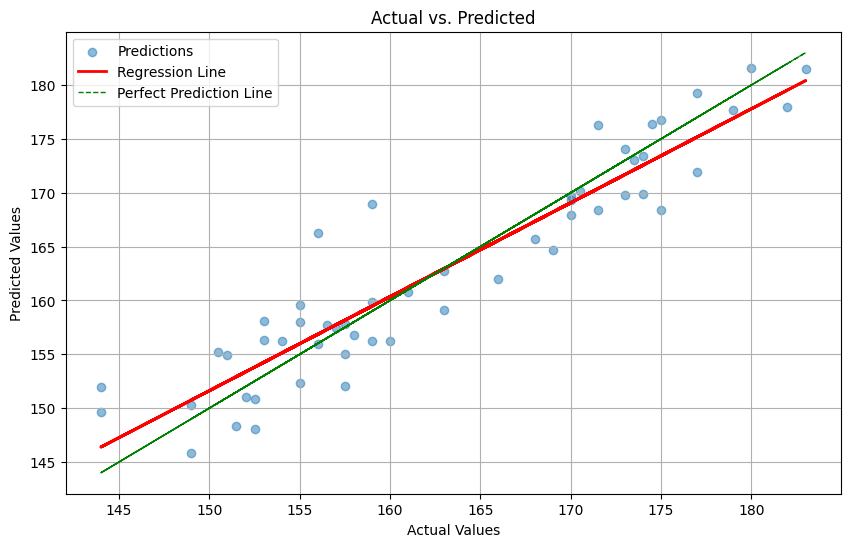

In [128]:
plt.figure(figsize=(10, 6))

plt.scatter(outputs, predictions, alpha=0.5)

m, b = np.polyfit(outputs, predictions, 1)
plt.plot(outputs, m*outputs + b, color='red', linewidth=2)

plt.plot(outputs, outputs, color='green', linewidth=1, linestyle='--')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(['Predictions', 'Regression Line', 'Perfect Prediction Line'])
plt.grid(True)
plt.show()

## Conclusiones

El modelo de regresión lineal en Python nos da un RMSE de 3.7 y un R2 de 0.87. Para una predicción de altura humana en cm, esto es un error aceptable. El modelo es bastante bueno, y se puede utilizar para predecir la altura de una persona a partir de sus restos óseos.